In [1]:
class Value:
    def __init__(self, data, children=(), _operation="", variable=""):
        self.data = data
        self.gradient = 0.0
        self.children = set(children)
        self.operation = _operation
        self.variable = variable
        self.backward_propagation = lambda: None
        self.debug = None

    def __repr__(self):
        return f"Value(data={self.data}, gradient={self.gradient})"

    def __add__(self, value_to_add):
        if not isinstance(value_to_add, Value):
            value_to_add = Value(value_to_add)
        result = Value(self.data + value_to_add.data, (self, value_to_add), "+")
        # result is b
        def _backward_propagation():
            self.gradient += 1.0 * result.gradient # a
            value_to_add.gradient += 1.0 * result.gradient # a
        result.backward_propagation = _backward_propagation
        return result

    def __mul__(self, value_to_mult):
        if not isinstance(value_to_mult, Value):
            value_to_mult = Value(value_to_mult)
        result = Value(self.data * value_to_mult.data, (self, value_to_mult), "*")
        def _backward_propagation():
            self.gradient += value_to_mult.data * result.gradient
            value_to_mult.gradient += self.data * result.gradient
        result.backward_propagation = _backward_propagation
        return result

    def __rmul__(self, other):
        # a = Value(1.0)
        # a = 2 * a fails if we don't have __rmul__ function to swap it.
        # 2.__mul__(Value(1.0)) ???
        return self * other # Value(1.0).__mul__(2)

    def tanh(self):
        import math
        tanh_function =(math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1)
        result = Value(tanh_function, (self, ), "tanh")

        # print(self.data)
        def _backward_propagation():
            # self.debug= self.data
            self.gradient +=  (1 - result.data**2) * result.gradient
        result.backward_propagation = _backward_propagation
        return result


    def __pow__(self, other):
        # other should not be Value object.
        assert isinstance(other, (int, float)), "value can be either float/int."
        result = Value(self.data**other, (self, ), f"pow{other}")
        def _backward_propagation():
            self.gradient += other * ((self.data)**(other - 1)) * result.gradient
        result.backward_propagation = _backward_propagation
        return result

    def __truediv__(self, other):
        result = self * other**-1
        return result

    def exp(self):
        import math
        result = Value(math.exp(self.data), (self, ), "exp")
        def _backward_propagation():
            self.gradient = math.exp(self.data) * result.gradient
        result.backward_propagation = _backward_propagation
        return result

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        # makes int + Value possible
        return self + other

    def backward(self):
        visited_nodes = set()
        final_sorted = []
        def topological_sort_graph(vertex):
            #  graph traversal in which each node v is visited only after all its dependencies are visited.
            if vertex not in visited_nodes:
                visited_nodes.add(vertex)
                for previous_vertex in vertex.children:
                    topological_sort_graph(previous_vertex)
                # No dependencies left
                final_sorted.append(vertex)
        topological_sort_graph(self)
        self.gradient = 1.0
        for v in reversed(final_sorted):
            v.backward_propagation()

In [2]:
import graphviz
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_graph(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = graphviz.Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.variable, n.data, n.gradient), shape='record')
        if n.operation:
            dot.node(name=str(id(n)) + n.operation, label=n.operation)
            dot.edge(str(id(n)) + n.operation, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.operation)

    return dot

In [3]:
x = Value(2.0) * Value(7.0) # 1. __init__ both Value class 2. (+) __add__

In [4]:
x.operation

'*'

In [5]:
x.children

{Value(data=2.0, gradient=0.0), Value(data=7.0, gradient=0.0)}

In [6]:
# inputs x1, x2 (2 features)
# weights w1, w2
# np.dot(x.w) + b

# def initiate_model_inputs_weights_bias():
x1 = Value(2.0); x1.variable= "x1"
x2 = Value(0.0); x2.variable= "x2"
w1 = Value(-3.0); w1.variable= "w1"
w2 = Value(1.0); w2.variable= "w2"
b = Value(6.8813735870195432); b.variable= "b"

x1_w1 = x1 * w1; x1_w1.variable= "x1_w1"
x2_w2 = x2 * w2; x2_w2.variable= "x2_w2"

x1_w1_x2_w2 = x1_w1 + x2_w2; x1_w1_x2_w2.variable= "x1_w1_x2_w2"

# add bias
intermediate_out = x1_w1_x2_w2 + b; intermediate_out.variable ="int_out"

# activation func (tanh) squach output i.e 0 <= output <= 1
output_for_single_neuron = intermediate_out.tanh(); output_for_single_neuron.variable ="neuron_output"


In [7]:
# list_prev_ops = list(output_for_single_neuron.children)
# list_prev_ops[1].children

In [8]:
# output_for_single_neuron.gradient

In [9]:
# forward pass
# dot_p = np.dot(w, x) + b
# neuron_out = tanh(dot_p)
# draw_graph(output_for_single_neuron)

In [10]:
# backward propagation
# Here we need to need to find the difference in change between neuron_output  and the prev children pts
# if we increase prev children pts data by small h.
# what happens ??

# output_for_single_neuron.gradient = 1.0 # d(output_for_single_neuron)/d(output_for_single_neuron)


#  d(output_for_single_neuron) / d(intermediate_out)
# local derivative
# intermediate_out.gradient = 1 - (output_for_single_neuron.data**2)


# chain rule: d(output_for_single_neuron) / d(b) = d(output_for_single_neuron)/d(intermediate_out) * d(intermediate_out)/d(b)
#  d(output_for_single_neuron) / d(b) = intermediate_out.gradient * 1.0

#  x1_w1_x2_w2.gradient = d(output_for_single_neuron) / d(x1_w1_x2_w2) = intermediate_out.gradient * 1.0

#  d(output_for_single_neuron) / d(x1_w1) = x2_w2.data * x1_w1_x2_w2.gradient

In [11]:
# output_for_single_neuron.gradient = 1.0


In [12]:
# output_for_single_neuron.data

In [13]:
# intermediate_out.operation

In [14]:
# initiate_model_inputs_weights_bias()
# initiate_model_inputs_weights_bias()

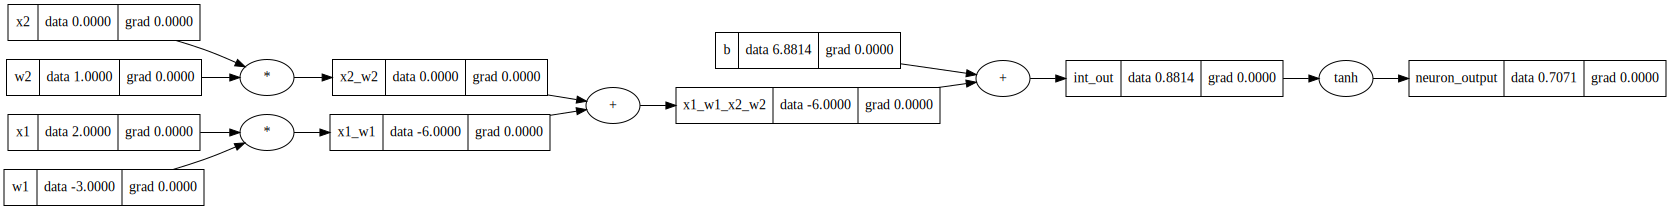

In [15]:
draw_graph(output_for_single_neuron)

In [16]:
# x = output_for_single_neuron.backward_propagation()

In [17]:
# output_for_single_neuron.gradient = 1.0

# output_for_single_neuron.backward_propagation()

# intermediate_out.backward_propagation()

# x1_w1_x2_w2.backward_propagation()
# b.backward_propagation()

# x1_w1.backward_propagation()
# x2_w2.backward_propagation()


# x1.backward_propagation()
# x2.backward_propagation()
# w1.backward_propagation()
# w2.backward_propagation()

In [18]:
# output_for_single_neuron.data

In [19]:
# intermediate_out.debug

In [20]:
visited_nodes = set()
final_sorted = []
def topological_sort_graph(vertex):
    #  graph traversal in which each node v is visited only after all its dependencies are visited.
    if vertex not in visited_nodes:
        visited_nodes.add(vertex)
        for previous_vertex in vertex.children:
            topological_sort_graph(previous_vertex)
        # No dependencies left
        final_sorted.append(vertex)

In [21]:
topological_sort_graph(output_for_single_neuron)

In [22]:
output_for_single_neuron.gradient = 1.0
for vertex in reversed(final_sorted):
    vertex.backward_propagation()

In [23]:
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


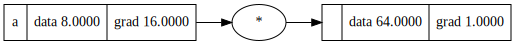

In [24]:

a = Value(8.0); a.variable = "a"
b = a * a

b.gradient = 1


b.backward_propagation()
# b.operation
draw_graph(b)



In [25]:
a = Value(8.0); a.variable = "a"

a +=1

In [26]:
a

Value(data=9.0, gradient=0.0)

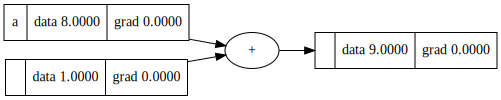

In [27]:
draw_graph(a)

In [28]:
a = Value(8.0); a.variable = "a"

a = 1* a

In [29]:
import numpy as np
class Neuron:
    def __init__(self, features_dim):
        import random
        self.w = [Value(random.uniform(-1, 1)) for _ in range(features_dim)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, X):
        # dot_result = np.dot(X, self.w) + self.b
        result = sum((wi*xi for wi,xi in zip(self.w, X)), self.b)
        return result.tanh()

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self,neurons_or_units_count, features_dim):
        self.neurons_init = [Neuron(features_dim) for  _ in range(neurons_or_units_count)]

    def __call__(self, X):
        result = [nn(X) for nn in self.neurons_init]
        return result[0] if len(result) == 1 else result

    def parameters(self):
        a = []
        for neuron in self.neurons_init:
            a.extend(neuron.parameters())
        return a


class MLP:
    # Multilayer perceptron
    def __init__(self, feature_input_dim, layers_neuron_list):
        # (3, [4, 4, 1])
        self.layer_init = []
        update_nn_list = [feature_input_dim] + layers_neuron_list
        for i in range(len(layers_neuron_list)):
            input_neurons_unit = update_nn_list[i] # 3, 4, 4
            neuron_units = update_nn_list[i+1] # 4, 4, 1
            self.layer_init.append(Layer(neuron_units, input_neurons_unit))

    def __call__(self, X):
        for layer in self.layer_init:
            out = layer(X)
        return out

    def parameters(self):
        a = []
        for layer in self.layer_init:
            a.extend(layer.parameters())
        return a

In [30]:
X = [2.0, 3.0, 4.0]
# n = Layer(4, 3) # 4 neurons, 3 dim features

In [31]:
# n(X)

In [32]:
mlp = MLP(3, [4, 4, 1])
# L1 = mlp.layer_init[0]
len(mlp.parameters())

41

In [33]:
k = mlp(X)
k

Value(data=-0.8224188306384661, gradient=0.0)

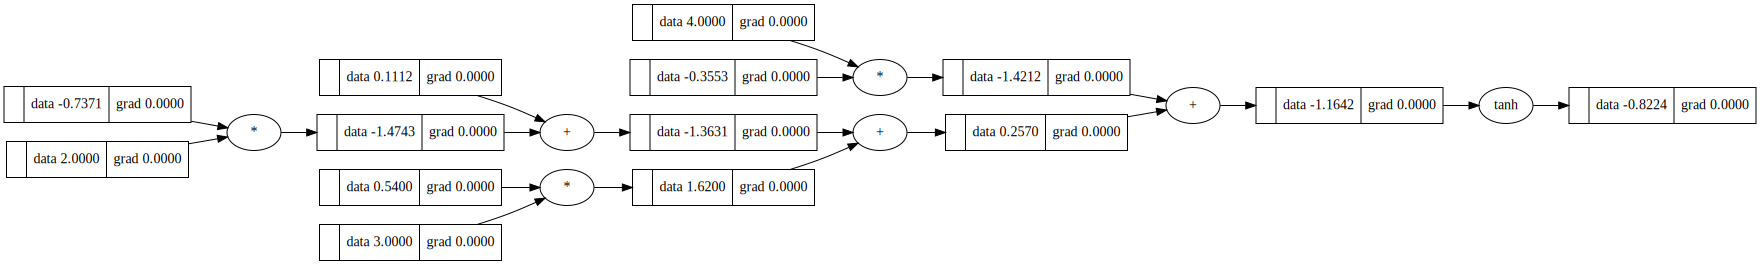

In [34]:
draw_graph(k)

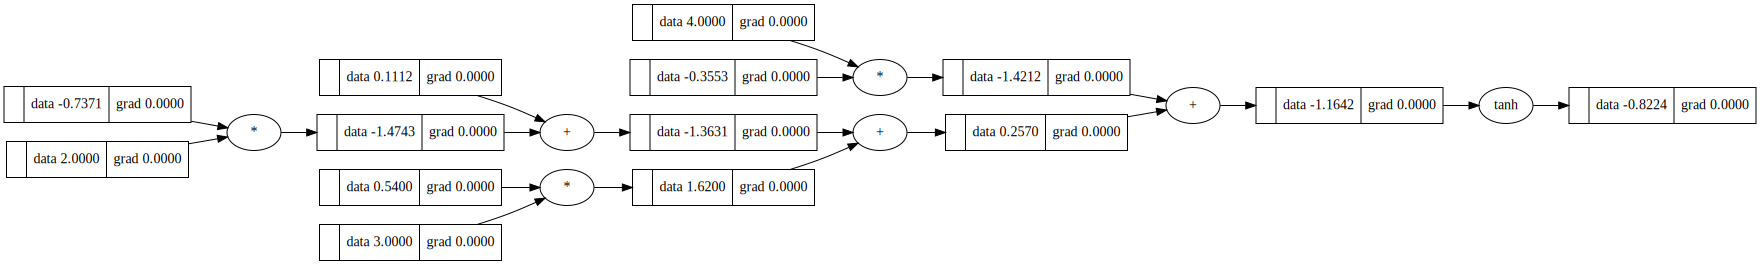

In [35]:
draw_graph(k)

In [36]:
k.backward()

In [37]:
mlp.layer_init[0].neurons_init[0].w

[Value(data=0.846738954945186, gradient=0.0),
 Value(data=-0.03709457794021409, gradient=0.0),
 Value(data=-0.5111077160448576, gradient=0.0)]

In [38]:
# L1(X)
y_prediction = mlp(X)

In [39]:
y_actual = [-1]

def mean_squared_error_loss(y_actual, y_prediction):
    error = 0
    for ya, yp in zip(y_actual, y_prediction):
        diff = (yp - ya)
        error += diff ** 2
    return  error / len(y_actual)

In [40]:
loss = mean_squared_error_loss(y_actual, y_prediction)

TypeError: zip argument #2 must support iteration

In [41]:
loss

NameError: name 'loss' is not defined

In [42]:
draw_graph(loss)

NameError: name 'loss' is not defined

In [43]:
loss.backward()

NameError: name 'loss' is not defined

In [44]:
# ((y_prediction[0] - (-1)) ** 2) / 1
draw_graph(loss)

NameError: name 'loss' is not defined

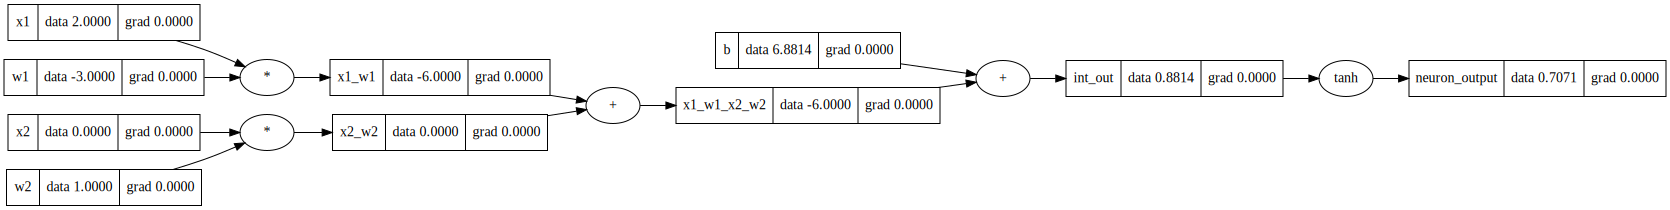

In [45]:
# inputs x1, x2 (2 features)
# weights w1, w2
# np.dot(x.w) + b

# def initiate_model_inputs_weights_bias():
x1 = Value(2.0); x1.variable= "x1"
x2 = Value(0.0); x2.variable= "x2"
w1 = Value(-3.0); w1.variable= "w1"
w2 = Value(1.0); w2.variable= "w2"
b = Value(6.8813735870195432); b.variable= "b"

x1_w1 = x1 * w1; x1_w1.variable= "x1_w1"
x2_w2 = x2 * w2; x2_w2.variable= "x2_w2"

x1_w1_x2_w2 = x1_w1 + x2_w2; x1_w1_x2_w2.variable= "x1_w1_x2_w2"

# add bias
intermediate_out = x1_w1_x2_w2 + b; intermediate_out.variable ="int_out"

# activation func (tanh) squach output i.e 0 <= output <= 1
output_for_single_neuron = intermediate_out.tanh(); output_for_single_neuron.variable ="neuron_output"

draw_graph(output_for_single_neuron)

In [46]:
output_for_single_neuron.backward()

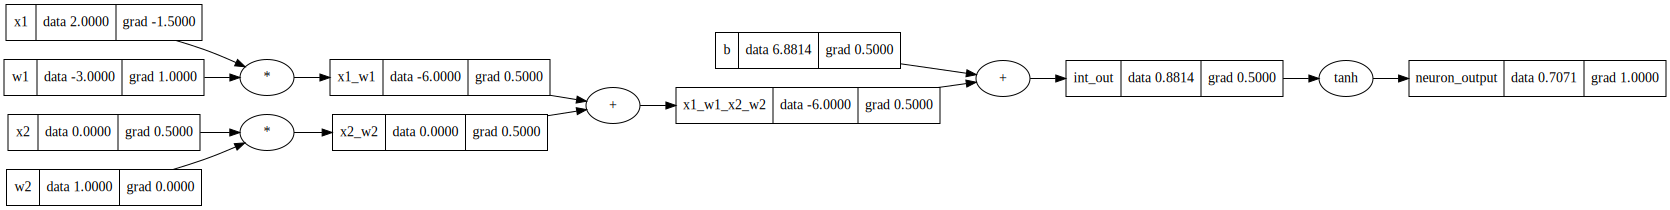

In [47]:
draw_graph(output_for_single_neuron)

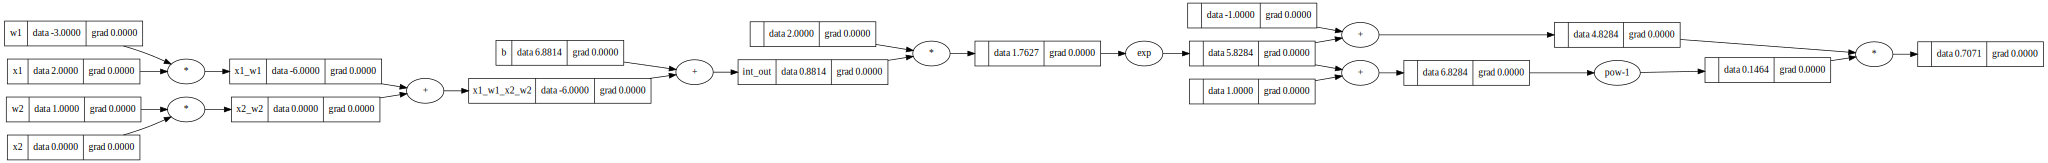

In [48]:
# inputs x1, x2 (2 features)
# weights w1, w2
# np.dot(x.w) + b

# def initiate_model_inputs_weights_bias():
x1 = Value(2.0); x1.variable= "x1"
x2 = Value(0.0); x2.variable= "x2"
w1 = Value(-3.0); w1.variable= "w1"
w2 = Value(1.0); w2.variable= "w2"
b = Value(6.8813735870195432); b.variable= "b"

x1_w1 = x1 * w1; x1_w1.variable= "x1_w1"
x2_w2 = x2 * w2; x2_w2.variable= "x2_w2"

x1_w1_x2_w2 = x1_w1 + x2_w2; x1_w1_x2_w2.variable= "x1_w1_x2_w2"

# add bias
intermediate_out = x1_w1_x2_w2 + b; intermediate_out.variable ="int_out"

# activation func (tanh) squach output i.e 0 <= output <= 1
# output_for_single_neuron = intermediate_out.tanh(); output_for_single_neuron.variable ="neuron_output"

e = (2 * intermediate_out).exp()
out = (e - 1)/ (e + 1)

draw_graph(out)

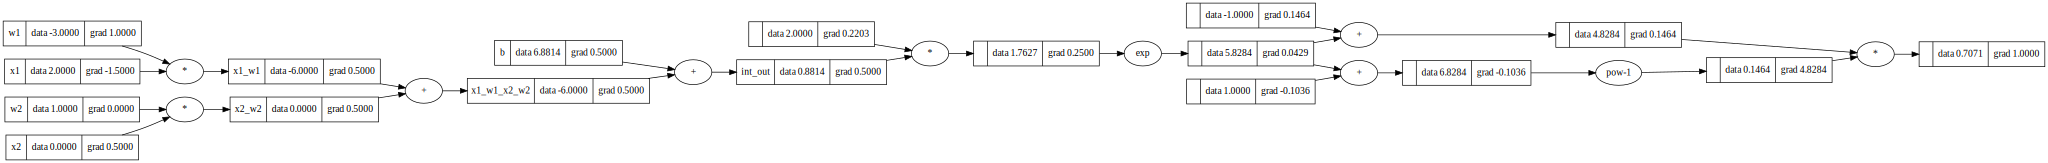

In [49]:
# a = Value(2.0)
# b = 6
# a / b

# out.gradient =1
out.backward()
draw_graph(out)

In [50]:
# draw_graph(out)

In [51]:
# draw_graph(out)

In [52]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
] # 4 forward passes
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [53]:
mlp = MLP(3, [4, 4, 1])

In [54]:
# mlp(xs[0])

In [55]:
# y_actual = [-1]

def mean_squared_error_loss(y_actual, y_prediction):
    error = 0
    for ya, yp in zip(y_actual, y_prediction):
        # print(ya, yp[0])
        diff = (yp[0] - ya)
        error += diff ** 2
    return  error / len(y_actual)

In [56]:
ypred =  [mlp(x) for x in xs]

In [57]:
ypred[0]

Value(data=0.8551331947679107, gradient=0.0)

In [71]:
loss = mean_squared_error_loss(ys, ypred)

In [72]:
loss


Value(data=1.470464762663998, gradient=0.0)

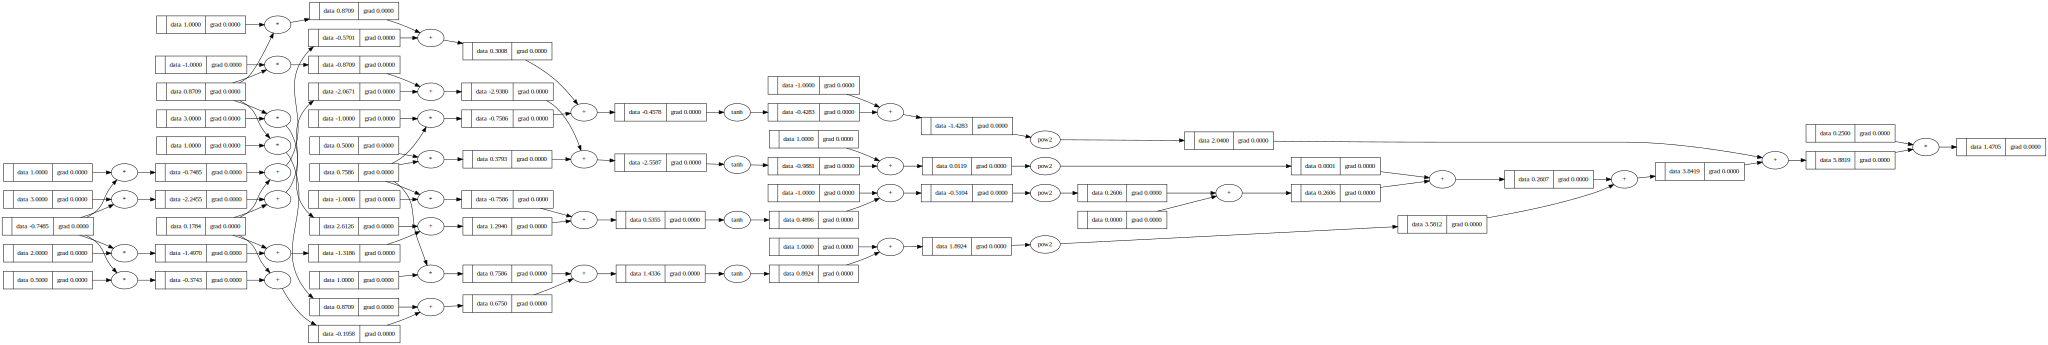

In [73]:
draw_graph(loss)

In [74]:
loss.backward()

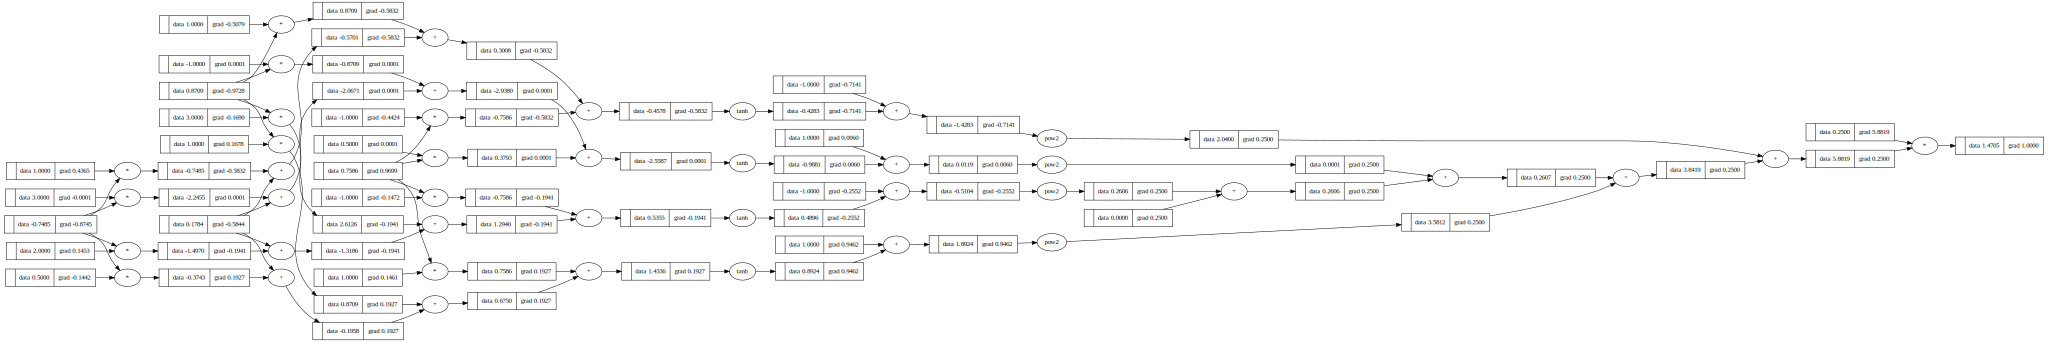

In [75]:
draw_graph(loss)

In [76]:
for p in mlp.parameters():
    print(p.data)

0.8702507005846833
-0.3681467328041903
0.810696121141325
0.3394106687614469
-0.643414419769323
0.9275239508158397
0.2401004789833172
-0.9174584068852816
0.34690432108165736
-0.06428870553046306
0.865473513553022
-0.5643161010963904
-0.17620799172063095
0.3734957982465774
-0.9878259683565729
-0.271031102235759
0.13923509597115524
-0.8300704640981289
-0.5752437250362219
-0.10641667994387616
0.7107615312150932
-0.532062627155955
0.5335717896286387
-0.7978841775912733
-0.8533953588328895
0.15664115904067555
0.7119834534337102
0.5013566675181835
-0.5313155152931051
-0.3291430311913395
0.7046911603493735
0.6726153078296837
-0.96796386460877
0.9978035413800781
0.4960380774923283
0.22840082017120533
-0.7485025857521195
0.8708796865581558
0.7585655028289868
-0.3300360382476335
0.1784026866129762


In [79]:
mlp.layer_init[0].neurons_init[0].w[1].gradient

0.0

In [78]:
# mlp.layer_init[0].neurons_init[0].w[0]